CS 671 Fall 2025

HW1, Q3

# Setup

In [1]:
!pip install --upgrade treefarms

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.5/694.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [treefarms]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
import os
from treefarms import TREEFARMS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sympy import to_dnf, simplify_logic

In [4]:
def to_dnf_string(leaf) -> str:
    """Converts a leaf of a tree to a DNF expression
    for the path of variables to reach the leaf.
    """
    rules = leaf['rules']
    dnf = []
    for feature, rule in rules.items():
        if rule['type'] == 'Categorical':
            if rule['positive']:
                dnf.append(f'({feature})')
            else:
                dnf.append(f'(~{feature})')
    return ' & '.join(dnf)

def convert_to_dnf(tree):
    """Converts a tree to a DNF of its leaves.
    e.g. the tree (right splits are 1, left are 0)
             x3
           //  \\
          x1    1
        //  \\
        0    x2
           //  \\
           1    0

    becomes the DNF

    (x1 & ~x2) | x3.
    """
    leaves = tree.__groups__()

    #otherwise, iterate through leaves
    pos_dnfs = []
    for leaf in leaves:
        if leaf['prediction'] == 1:
            pos_dnfs.append(to_dnf_string(leaf))

    # cover case where tree simplifies to True or False (like a stump, or a
    # tree with many leaves that all predict the same thing)
    if len(pos_dnfs) == 0: # if no leaf can ever predict positive:
        return False

    return to_dnf(' | '.join(pos_dnfs))

def get_simplified_dnf(tree):
    """Converts a tree to a simplified DNF of its leaves.
    """
    pos_dnf = convert_to_dnf(tree)
    simple_pos_dnf = simplify_logic(pos_dnf, form='dnf', force=True)
    return simple_pos_dnf

def print_dnf(dnf, features):
    """Print a DNF using the given feature names.

    This is needed because sympy representations of DNFs use
    feature indices instead of their names. For example,
    the expression (a & ~b) | c will be represented as
    (feature_0 & ~feature_1) | feature_2.

    Use this to print DNF expressions in part d).

    Parameters
    ----------
        dnf: A sympy expression representing a DNF.
        features: A list of strings representing the feature names.
    """
    dnf_str = str(dnf)
    features = list(features)
    for i in reversed(range(0, len(features))):
        dnf_str = dnf_str.replace(f'feature_{i}', features[i])
    print(dnf_str)

In [5]:
df = pd.read_csv('data/compas_hw1_q3.csv')
target = 'recidivate-within-two-years:1'
X = df.drop(target, axis=1)
y = df[target]
h = df.columns

# split the data into 70% train, 20% val, 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/0.9, random_state=11)

print('train size:', X_train.shape[0]/X.shape[0])
print('val size:', X_val.shape[0]/X.shape[0])
print('test size:', X_test.shape[0]/X.shape[0])

train size: 0.6998696974084262
val size: 0.2000868683943825
test size: 0.10004343419719125


In [6]:
# train TREEFARMS model
config = {
    "regularization": 0.01,  # regularization penalizes the tree with more leaves.
    "rashomon_bound_multiplier": 0.05,  # rashomon bound multiplier indicates how large of a Rashomon set would you like to get
    "depth_budget": 6
}

model = TREEFARMS(config)

model.fit(X_train, y_train)

models = [model[i] for i in range(model.get_tree_count())]

null
Finding Optimal Objective...
treefarms reported successful execution
{
  "false": {
    "false": {
      "complexity": 0.009999999776482582,
      "loss": 0.02027306519448757,
      "name": "recidivate-within-two-years:1",
      "prediction": 1
    },
    "feature": 7,
    "name": "juvenile-crimes:=0",
    "reference": 1,
    "relation": "==",
    "true": {
      "complexity": 0.009999999776482582,
      "loss": 0.21679767966270447,
      "name": "recidivate-within-two-years:1",
      "prediction": 0
    },
    "type": "integral"
  },
  "feature": 11,
  "model_objective": 0.3754695951938629,
  "name": "priors:>3",
  "reference": 1,
  "relation": "==",
  "true": {
    "complexity": 0.009999999776482582,
    "loss": 0.10839883983135223,
    "name": "recidivate-within-two-years:1",
    "prediction": 1
  },
  "type": "integral"
}
{
  "false": {
    "complexity": 0.009999999776482582,
    "loss": 0.0376499779522419,
    "name": "recidivate-within-two-years:1",
    "prediction": 1
  },


This is a TimberTrek representation of the Rashomon set of decision trees. Tree splits at different depths are represented in concentric rings, with rings further from the center representing deeper levels of the trees. Grey bars are individual models in the Rashomon set -- try clicking around to find models that you like, and play around with the search function to get rid of models using certain features!

In [21]:
model.visualize()

Generating decision paths from 1603 trees: 100%|██████████| 1603/1603 [00:02<00:00, 581.76it/s]


<iframe
 srcdoc="<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8" /><meta name="viewport" content="width=device-width, initial-scale=1.0" /><title>TimberTrek</title><style>html{font-size:16px;-moz-osx-font-smoothing:grayscale;-webkit-font-smoothing:antialiased;text-rendering:optimizeLegibility;-webkit-text-size-adjust:100%;-moz-text-size-adjust:100%}html,body{position:relative;width:100%;height:100%}body{margin:0;padding:0;box-sizing:border-box;font-family:-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Oxygen-Sans,Ubuntu,Cantarell,Helvetica Neue,sans-serif;color:#4a4a4a;font-size:1em;font-weight:400;line-height:1.5}*,:after,:before{box-sizing:inherit}a{color:#0064c8;text-decoration:none}a:hover{text-decoration:underline}a:visited{color:#0050a0}label{display:block}input,button,select,textarea{font-family:inherit;font-size:inherit;-webkit-padding:.4em 0;padding:.4em;margin:0 0 .5em;box-sizing:border-box;border:1px solid #ccc;border-radius:2px}input:disabled{color:#ccc}button{color:#333;background-color:#f4f4f4;outline:none}button:disabled{color:#999}button:not(:disabled):active{background-color:#ddd}button:focus{border-color:#666}</style><script defer src='data:text/javascript;base64,dmFyIEk3PU9iamVjdC5kZWZpbmVQcm9wZXJ0eTt2YXIgRjc9KGllLHplLFMpPT56ZSBpbiBpZT9JNyhpZSx6ZSx7ZW51bWVyYWJsZTohMCxjb25maWd1cmFibGU6ITAsd3JpdGFibGU6ITAsdmFsdWU6U30pOmllW3plXT1TO3ZhciBBPShpZSx6ZSxTKT0+KEY3KGllLHR5cGVvZiB6ZSE9InN5bWJvbCI/emUrIiI6emUsUyksUyksbDI9KGllLHplLFMpPT57aWYoIXplLmhhcyhpZSkpdGhyb3cgVHlwZUVycm9yKCJDYW5ub3QgIitTKX07dmFyIEJsPShpZSx6ZSxTKT0+KGwyKGllLHplLCJyZWFkIGZyb20gcHJpdmF0ZSBmaWVsZCIpLFM/Uy5jYWxsKGllKTp6ZS5nZXQoaWUpKSx2ZT0oaWUsemUsUyk9PntpZih6ZS5oYXMoaWUpKXRocm93IFR5cGVFcnJvcigiQ2Fubm90IGFkZCB0aGUgc2FtZSBwcml2YXRlIG1lbWJlciBtb3JlIHRoYW4gb25jZSIpO3plIGluc3RhbmNlb2YgV2Vha1NldD96ZS5hZGQoaWUpOnplLnNldChpZSxTKX07dmFyIHNlPShpZSx6ZSxTKT0+KGwyKGllLHplLCJhY2Nlc3MgcHJpdmF0ZSBtZXRob2QiKSxTKTt2YXIgdGltYmVydHJlaz1mdW5jdGlvbigpe3ZhciAkcyxjMixlYSx1Mix0YSxoMixuYSxmMixyYSxkMixpYSxwMixzYSxtMixhYSxnMixvYSx2MixsYSx3MixsbixucixjYSx5Mix6aSxZbCx1YSxiMixEaSxoYSx4MixWaSxHbCxmYSxDMixkYSxrMixwYSxTMixtYSxfMixnYSxMMix2YSxUMix3YSxNMixTbixacixBaSxYbCxGcixWYSxQcixBYSx5YSx6MixiYSxEMixfbixCcixJaSxKbCx4YSxWMixDYSxBMixrYSxJMixTYSxGMixfYSxQMixMYSxIMixUYSxFMixNYSxSMixGaSxRbDsidXNlIHN0cmljdCI7ZnVuY3Rpb24gaWUoKXt9Y29uc3QgemU9ZT0+ZTtmdW5jdGlvbiBTKGUsdCxuLHIsaSl7ZS5fX3N2ZWx0ZV9tZXRhPXtsb2M6e2ZpbGU6dCxsaW5lOm4sY29sdW1uOnIsY2hhcjppfX19ZnVuY3Rpb24gS2woZSl7cmV0dXJuIGUoKX1mdW5jdGlvbiAkbCgpe3JldHVybiBPYmplY3QuY3JlYXRlKG51bGwpfWZ1bmN0aW9uIEhlKGUpe2UuZm9yRWFjaChLbCl9ZnVuY3Rpb24gcnIoZSl7cmV0dXJuIHR5cGVvZiBlPT0iZnVuY3Rpb24ifWZ1bmN0aW9uIEtlKGUsdCl7cmV0dXJuIGUhPWU/dD09dDplIT09dHx8ZSYmdHlwZW9mIGU9PSJvYmplY3QifHx0eXBlb2YgZT09ImZ1bmN0aW9uIn1sZXQgWmk7ZnVuY3Rpb24gWXIoZSx0KXtyZXR1cm4gWml8fChaaT1kb2N1bWVudC5jcmVhdGVFbGVtZW50KCJhIikpLFppLmhyZWY9dCxlPT09WmkuaHJlZn1mdW5jdGlvbiBOMihlKXtyZXR1cm4gT2JqZWN0LmtleXMoZSkubGVuZ3RoPT09MH1jb25zdCBlMT10eXBlb2Ygd2luZG93PCJ1IjtsZXQgSWE9ZTE/KCk9PndpbmRvdy5wZXJmb3JtYW5jZS5ub3coKTooKT0+RGF0ZS5ub3coKSxGYT1lMT9lPT5yZXF1ZXN0QW5pbWF0aW9uRnJhbWUoZSk6aWU7Y29uc3QgaXI9bmV3IFNldDtmdW5jdGlvbiB0MShlKXtpci5mb3JFYWNoKHQ9Pnt0LmMoZSl8fChpci5kZWxldGUodCksdC5mKCkpfSksaXIuc2l6ZSE9PTAmJkZhKHQxKX1mdW5jdGlvbiBQYShlKXtsZXQgdDtyZXR1cm4gaXIuc2l6ZT09PTAmJkZhKHQxKSx7cHJvbWlzZTpuZXcgUHJvbWlzZShuPT57aXIuYWRkKHQ9e2M6ZSxmOm59KX0pLGFib3J0KCl7aXIuZGVsZXRlKHQpfX19ZnVuY3Rpb24gbjEoZSx0KXtlLmFwcGVuZENoaWxkKHQpfWZ1bmN0aW9uIFZ0KGUsdCxuKXtjb25zdCByPUhhKGUpO2lmKCFyLmdldEVsZW1lbnRCeUlkKHQpKXtjb25zdCBpPV8oInN0eWxlIik7aS5pZD10LGkudGV4dENvbnRlbnQ9bixyMShyLGkpfX1mdW5jdGlvbiBIYShlKXtpZighZSlyZXR1cm4gZG9jdW1lbnQ7Y29uc3QgdD1lLmdldFJvb3ROb2RlP2UuZ2V0Um9vdE5vZGUoKTplLm93bmVyRG9jdW1lbnQ7cmV0dXJuIHQmJnQuaG9zdD90OmUub3duZXJEb2N1bWVudH1mdW5jdGlvbiBXMihlKXtjb25zdCB0PV8oInN0eWxlIik7cmV0dXJuIHIxKEhhKGUpLHQpLHQuc2hlZXR9ZnVuY3Rpb24gcjEoZSx0KXtyZXR1cm4gbjEoZS5oZWFkfHxlLHQpLHQuc2hlZXR9ZnVuY3Rpb24gaTEoZSx0LG4pe2UuaW5zZXJ0QmVmb3JlKHQsbnx8bnVsbCl9ZnVuY3Rpb24gQmkoZSl7ZS5wYXJlbnROb2RlLnJlbW92ZUNoaWxkKGUpfWZ1bmN0aW9uIGV

# a) Exploring the Rashomon set

The Rashomon set fitting code is provided for you in the setup.

## i. Compute and store the number of leaves of each model in the Rashomon set, the train accuracy of each model, the validation accuracy of each model, and the validation f1 score of each model.

In [7]:
X_train

,sex:Female,age:<21,age:<23,age:<26,age:<46,juvenile-felonies:=0,juvenile-misdemeanors:=0,juvenile-crimes:=0,priors:=0,priors:=1,priors:2-3,priors:>3
6703,1,0,0,0,0,1,1,1,0,0,0,1
5226,0,1,1,1,1,1,1,1,0,1,0,0
6893,1,1,1,1,1,1,1,1,1,0,0,0
1607,0,1,1,1,1,1,1,1,1,0,0,0
6459,0,0,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2647,0,0,0,0,1,1,1,1,1,0,0,0
1286,0,0,0,0,1,1,1,1,0,0,1,0
6426,0,0,0,0,1,0,0,0,0,0,0,1
6312,0,0,0,0,0,1,1,1,1,0,0,0


In [12]:
leaves = []
train_accs = []
val_accs = []
f1_scores = []

def calculate_accuracy(ground_truth, preds):
    n = len(preds)
    correct = 0
    for i in range(n):
        if(ground_truth.iloc[i] == preds[i]):
            correct += 1
    return correct / n

for i, tree in enumerate(models):
    numLeaves = len(models[i].__groups__())
    leaves.append(numLeaves)

    # Calculate accuracy for training set
    train_preds = models[i].predict(X_train)
    train_accs.append(calculate_accuracy(y_train, train_preds))

    # Calculate accuracy for validation set
    val_preds = models[i].predict(X_val)
    val_accs.append(calculate_accuracy(y_val, val_preds))
    
    # Calculate F1 score for validation set
    f1_scores.append(f1_score(y_val, val_preds))



## ii. Report the minimum and maximum of each item you computed in part i.

In [18]:
# Max/min number of leaves
print(f"Maximum number of leaves: {max(leaves)}\nMinimum number of leaves: {min(leaves)}\n")

# Max/min training accuracy
print(f"Maximum training accuracy: {max(train_accs)}\nMinimum training accuracy: {min(train_accs)}\n")

# Max/min validation accuracy
print(f"Maximum validation accuracy: {max(val_accs)}\nMinimum validation accuracy: {min(val_accs)}\n")

# Max/min validation f1
print(f"Maximum validation f1: {max(f1_scores)}\nMinimum validation f1: {min(f1_scores)}\n")

Maximum number of leaves: 6
Minimum number of leaves: 2

Maximum training accuracy: 0.6721141911460489
Minimum training accuracy: 0.6344642118328506

Maximum validation accuracy: 0.683068017366136
Minimum validation accuracy: 0.6353111432706223

Maximum validation f1: 0.6751233262861169
Minimum validation f1: 0.5607476635514018



# b) Calculating Demographic Parity Difference

## i. Fill in the provided function for computing demographic parity difference.

In [77]:
def demographic_parity_difference(model, X, sensitive_feature):
    """Calculate the demographic parity difference of a model.

    Parameters
    ----------
        model: A model implementing the predict function.
        X: A pandas dataframe of features.
        sensitive_feature: The name of the sensitive feature.

    Returns
    ----------
        (float) The demographic parity difference.
    """
    predictions = model.predict(X)

    sensitive_values = X[sensitive_feature]
    
    protected_group = sensitive_values == 1
    protected_predictions = predictions[protected_group]
    protected_positive_rate = np.mean(protected_predictions) if len(protected_predictions) > 0 else 0

    unprotected_group = sensitive_values == 0
    unprotected_predictions = predictions[unprotected_group]
    unprotected_positive_rate = np.mean(unprotected_predictions) if len(unprotected_predictions) > 0 else 0
    
    # Return the absolute difference (demographic parity difference)
    return unprotected_positive_rate-protected_positive_rate

## ii. Calculate the demographic parity difference of all of the models in the Rashomon set for the `sex:Female` feature. Report the minimum and maximum demographic parity difference inside the Rashomon set.

In [85]:
female_demographic_parities = []

for m in models:
    female_demographic_parities.append(demographic_parity_difference(m, X_val, "sex:Female"))

print(f"Minimum 'sex:Female' Demographic Parity Difference: {min(female_demographic_parities)}")
print(f"Maximum 'sex:Female' Demographic Parity Difference: {max(female_demographic_parities)}")

Minimum 'sex:Female' Demographic Parity Difference: 0.14080928388041763
Maximum 'sex:Female' Demographic Parity Difference: 0.4460992224683723


## iii. Interpret the minimum and maximum demographic parity differences inside the Rashomon set. What do the results imply about the variety of ways that the models in the Rashomon set decide if someone is likely to recidivate based on their sex?

The huge discrepency of 0.34 between the maximum and minimum demgraphic parity differences shows a massive variety of ways that the models in the Rashomon set decide if someone is likely to recidivate based on sex. Some models (near the 0.0904 DPD) are pretty even in their determinations between male and female. On the other hand, those models closer to 0.430 DPD are more biased, favoring one gender to be more likely to recidivate.

# c) Filtering the Rashomon set

## i. Plot histograms, with 20 bins, of the validation accuracies, demographic parity differences w.r.t `sex:Female`, and validation f1 scores in the Rashomon set. We will inspect these histograms to choose cut points to filter the Rashomon set.

Text(0, 0.5, 'Count')

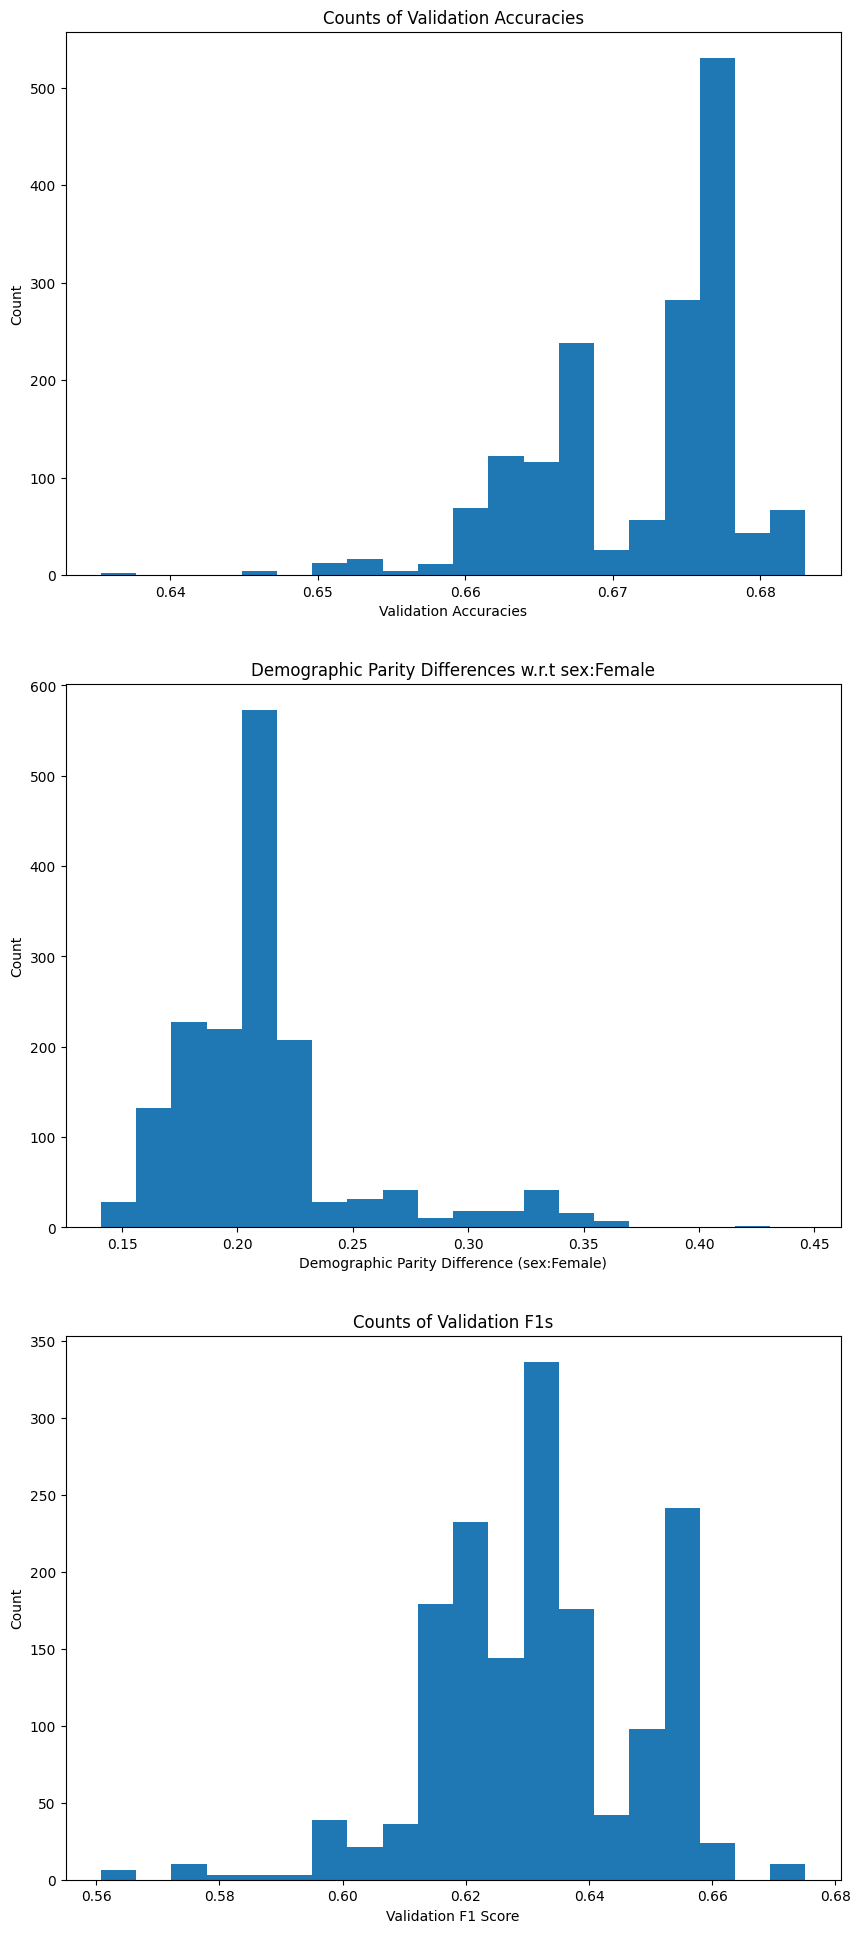

In [86]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10,24))

axes[0].hist(val_accs, bins=20)
axes[0].set_title("Counts of Validation Accuracies")
axes[0].set_xlabel("Validation Accuracies")
axes[0].set_ylabel("Count")

axes[1].hist(female_demographic_parities, bins=20)
axes[1].set_title("Demographic Parity Differences w.r.t sex:Female")
axes[1].set_xlabel("Demographic Parity Difference (sex:Female)")
axes[1].set_ylabel("Count")

axes[2].hist(f1_scores, bins=20)
axes[2].set_title("Counts of Validation F1s")
axes[2].set_xlabel("Validation F1 Score")
axes[2].set_ylabel("Count")


## ii. Filter the Rashomon set down to models with validation accuracies > 0.67. How many models are you left with?

In [87]:
filter_idxs = [idx for idx in range(len(val_accs)) if val_accs[idx] > 0.67]

print(f"There are {len(filter_idxs)} models left with validation accuracies > 0.67")

There are 1004 models left with validation accuracies > 0.67


## iii. Filter again down to models with validation demographic parity differences < 0.2. How many models are you left with?

In [88]:
filter2_idxs = [idx for idx in filter_idxs if female_demographic_parities[idx] < 0.2]

print(f"There are {len(filter2_idxs)} models left with validation demographic parity differences < 0.2.")

There are 103 models left with validation demographic parity differences < 0.2.


## iv. Filter once more to models with a validation f1-score > 0.65. How many models are you left with?

In [89]:
filter3_idxs = [idx for idx in filter2_idxs if f1_scores[idx] > 0.65]

print(f"There are {len(filter3_idxs)} models left with validation f1-scores > 0.65.")

There are 34 models left with validation f1-scores > 0.65.


# d) Inspecting the remaining models

## i. Use the provided helper code to examine the logical forms of the remaining models. How many unique simplified DNFs did we filter down to?

In [90]:
dnfs = set()
for i in filter3_idxs:
    dnfs.add(get_simplified_dnf(models[i]))

In [91]:
print(f"There are {len(dnfs)} unique simplified DNFs remaining.")

There are 9 unique simplified DNFs remaining.


In [92]:
# Let's examine the DNFs more closely
print("All unique simplified DNFs:")
print("=" * 50)

# Convert set to list for easier indexing
dnf_list = list(dnfs)

for i, dnf in enumerate(dnf_list):
    print(f"{i+1}. {dnf}")
    print_dnf(dnf, X.columns)
    print("-" * 30)


All unique simplified DNFs:
1. feature_11 | ~feature_7 | (feature_10 & feature_3) | (feature_1 & ~feature_10)
priors:>3 | ~juvenile-crimes:=0 | (priors:2-3 & age:<26) | (age:<21 & ~priors:2-3)
------------------------------
2. (feature_10 & feature_3) | (feature_1 & ~feature_10) | (feature_11 & ~feature_10) | (~feature_10 & ~feature_7)
(priors:2-3 & age:<26) | (age:<21 & ~priors:2-3) | (priors:>3 & ~priors:2-3) | (~priors:2-3 & ~juvenile-crimes:=0)
------------------------------
3. feature_1 | feature_11 | ~feature_7 | (feature_10 & feature_3)
age:<21 | priors:>3 | ~juvenile-crimes:=0 | (priors:2-3 & age:<26)
------------------------------
4. feature_1 | (feature_10 & feature_3) | (feature_11 & ~feature_10) | (~feature_10 & ~feature_7)
age:<21 | (priors:2-3 & age:<26) | (priors:>3 & ~priors:2-3) | (~priors:2-3 & ~juvenile-crimes:=0)
------------------------------
5. ~feature_7 | (feature_10 & feature_3) | (feature_1 & ~feature_10) | (feature_11 & ~feature_10)
~juvenile-crimes:=0 | (pri

## ii. Among the unique simplified DNF forms that you have remaining, use logical equivalence between expressions along with what you know about the features to identify how many of these are truly unique. (Hint: for example, you can't have priors:>3 and priors:=0!)

## iii. The few remaining models are very similar to each other! Which one of them would you deploy? There are no wrong answers to this question.

In [94]:
# Compute the model with the greatest F1 score on the test set
best_model_idx = -1
best_test_f1 = -1.0

for i, m in enumerate(models):
    test_preds = m.predict(X_test)
    test_f1 = f1_score(y_test, test_preds)
    if test_f1 > best_test_f1:
        best_test_f1 = test_f1
        best_model_idx = i

print(f"Best test F1: {best_test_f1:.4f} at model index {best_model_idx}")


Best test F1: 0.6402 at model index 452
